### Data Dictionary

The goal of this exercise is to do Model Development and Validation to find the answer to the Question 4 of the problem statement:

Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer
from feature_engine import outlier_removers as outr

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Exploration

In [34]:
df = pd.read_csv("bronxbinarytrain.csv")

In [35]:
df

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
0,1268,35.0,0.35,2.0,2.0,3650,95.00,1,1.67,2628,1268,0.90,2458,50,70,0
1,7839,45.0,3.08,2.0,3.0,4275,45.00,1,5.00,2628,6018,3.00,2458,83,103,0
2,1910,30.0,0.65,2.0,1.0,2917,58.33,1,2.00,2628,1910,0.60,2458,-6,14,0
3,1968,40.0,0.39,2.0,1.0,5000,100.00,1,2.50,2628,1968,0.60,2458,75,95,1
4,924,30.0,0.51,2.0,2.0,1800,100.00,1,2.00,2628,924,0.90,2458,75,95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89849,2340,46.0,0.90,2.0,4.8,2500,100.00,1,2.00,2628,2000,3.44,2458,65,85,1
89850,3432,52.0,1.51,2.0,2.0,2266,103.00,1,3.00,2628,3432,1.10,2458,35,55,1
89851,2420,47.0,1.10,2.0,2.0,2204,100.17,1,2.00,2628,1760,0.90,2458,45,65,1
89852,2320,58.0,0.93,2.0,2.0,2500,100.00,1,2.00,2628,2320,0.90,2458,80,100,1


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89854 entries, 0 to 89853
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BldgArea       89854 non-null  int64  
 1   BldgDepth      89854 non-null  float64
 2   BuiltFAR       89854 non-null  float64
 3   CommFAR        89854 non-null  float64
 4   FacilFAR       89854 non-null  float64
 5   LotArea        89854 non-null  int64  
 6   LotDepth       89854 non-null  float64
 7   NumBldgs       89854 non-null  int64  
 8   NumFloors      89854 non-null  float64
 9   OfficeArea     89854 non-null  int64  
 10  ResArea        89854 non-null  int64  
 11  ResidFAR       89854 non-null  float64
 12  RetailArea     89854 non-null  int64  
 13  Age            89854 non-null  int64  
 14  Period         89854 non-null  int64  
 15  ComplaintType  89854 non-null  int64  
dtypes: float64(7), int64(9)
memory usage: 11.0 MB


In [37]:
df.describe(include='all')

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
count,89854.000000,89854.000000,89854.000000,89854.000000,89854.000000,89854.000000,89854.000000,89854.0,89854.000000,89854.000000,89854.000000,89854.000000,89854.000000,89854.000000,89854.000000,89854.000000
mean,3023.194026,50.294414,1.082459,1.969679,2.878297,3712.115064,98.212669,1.0,2.375609,2608.339072,2350.192345,1.734596,2419.994536,56.995092,77.179146,0.502493
std,2010.530805,19.907146,0.711358,0.179440,1.576991,2576.492232,16.852655,0.0,1.043984,181.223220,1325.998493,1.254187,228.640254,28.762429,28.716494,0.499997
min,1.000000,2.000000,0.010000,0.500000,1.000000,1.000000,0.080000,1.0,0.500000,50.000000,100.000000,0.500000,100.000000,-91.000000,3.000000,0.000000
25%,1771.000000,36.000000,0.640000,2.000000,2.000000,2200.000000,95.000000,1.0,2.000000,2628.000000,1482.000000,0.900000,2458.000000,40.000000,60.000000,0.000000
50%,2340.000000,46.000000,0.900000,2.000000,2.000000,2513.000000,100.000000,1.0,2.000000,2628.000000,2000.000000,1.250000,2458.000000,65.000000,85.000000,1.000000
75%,3288.000000,55.000000,1.250000,2.000000,4.800000,4250.000000,102.420000,1.0,3.000000,2628.000000,2616.000000,2.430000,2458.000000,75.000000,95.000000,1.000000
max,7839.000000,112.000000,3.080000,2.000000,10.000000,10400.000000,124.680000,1.0,6.000000,2628.000000,6018.000000,7.020000,2458.000000,180.000000,200.000000,1.000000


In [38]:
df.shape

(89854, 16)

In [39]:
df.columns

Index(['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'Age', 'Period', 'ComplaintType'],
      dtype='object')

In [40]:
df['ComplaintType'].value_counts()

1    45151
0    44703
Name: ComplaintType, dtype: int64

### Data Visualization

### Univariate Data Exploration

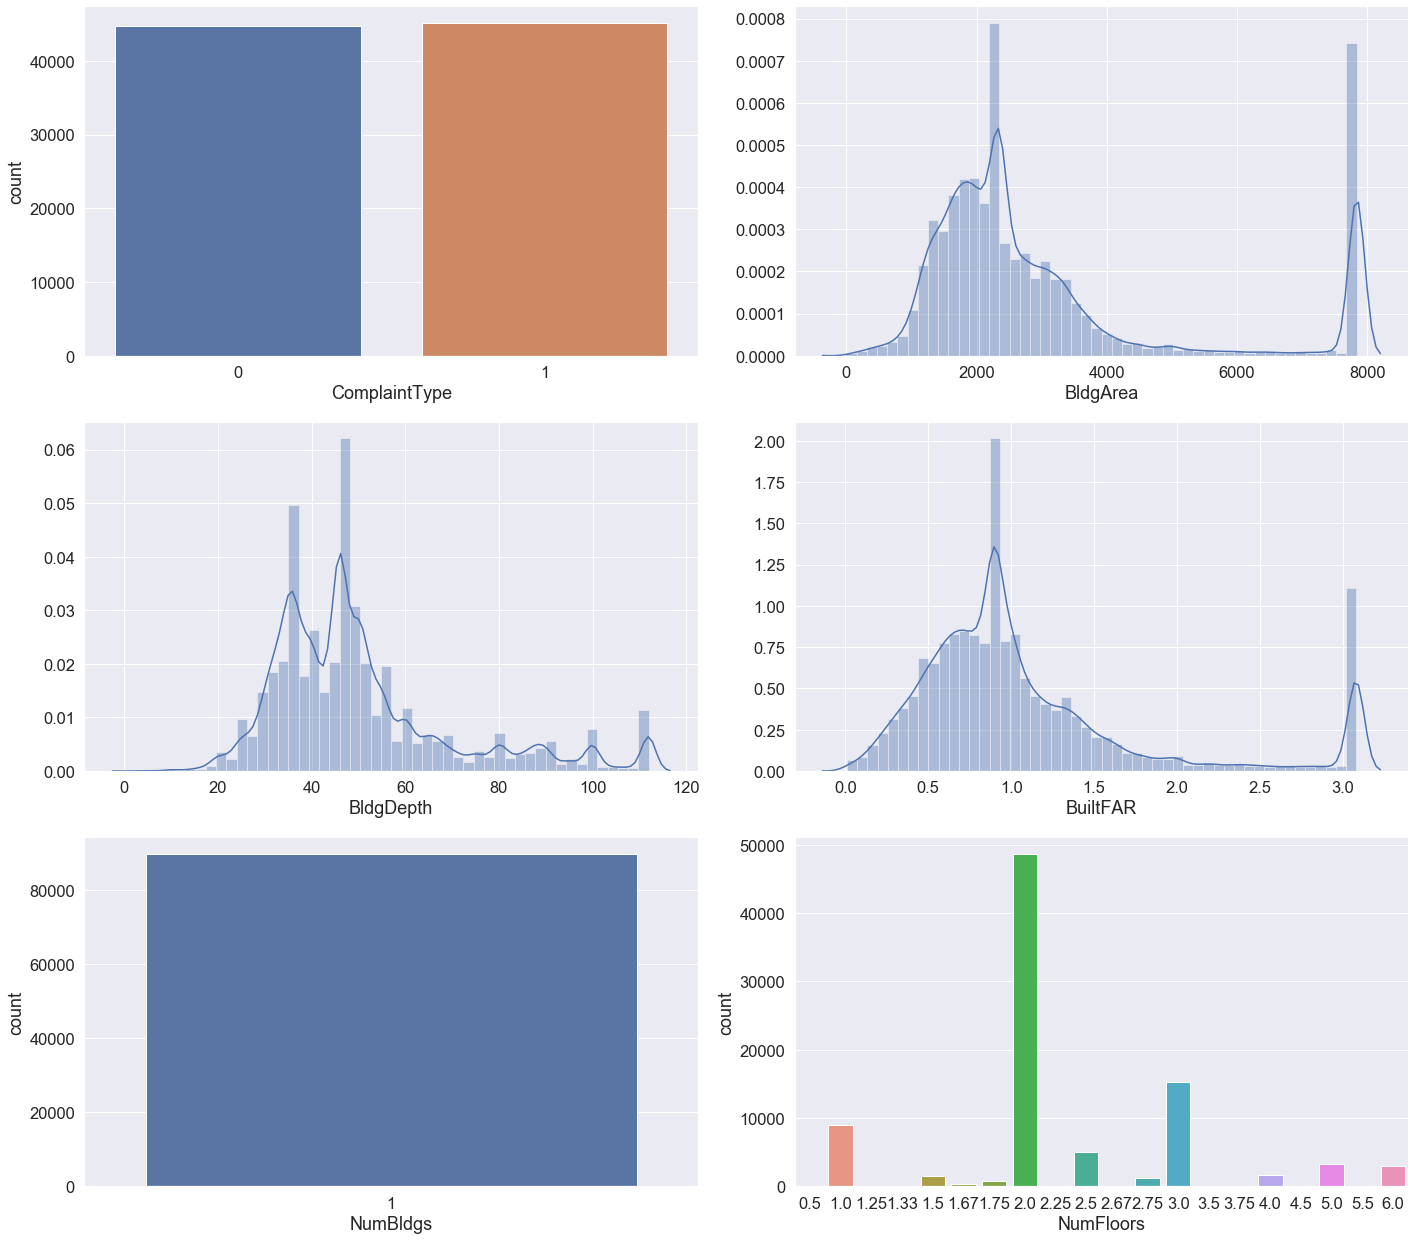

In [41]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.ComplaintType)
plt.subplot(7,2,2)
sns.distplot(df.BldgArea)
plt.subplot(7,2,3)
sns.distplot(df.BldgDepth)
plt.subplot(7,2,4)
sns.distplot(df.BuiltFAR)
plt.subplot(7,2,5)
sns.countplot(df.NumBldgs)
plt.subplot(7,2,6)
sns.countplot(df.NumFloors)
# plt.subplot(7,2,7)
# sns.countplot(df.Age)
# plt.subplot(7,2,8)
# sns.countplot(df.Period)
# plt.subplot(7,2,9)
# sns.countplot()
# plt.subplot(7,2,10)
# sns.countplot()
# plt.subplot(7,2,11)
# sns.countplot()
# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [42]:
df.corr()

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
BldgArea,1.000000,0.787221,0.762170,-0.075544,0.435332,0.613268,0.159553,NaN,0.628390,-0.079497,0.779505,0.435297,-0.113539,-0.024406,-0.001723,-0.000722
BldgDepth,0.787221,1.000000,0.599139,-0.097850,0.412817,0.482736,0.241943,NaN,0.400949,-0.079774,0.587110,0.391856,-0.094878,0.031902,0.051549,-0.000863
BuiltFAR,0.762170,0.599139,1.000000,0.032959,0.490807,0.196427,-0.070595,NaN,0.795322,-0.045641,0.794447,0.503926,-0.170451,-0.025140,-0.007459,0.002793
CommFAR,-0.075544,-0.097850,0.032959,1.000000,0.049721,-0.145954,-0.028959,NaN,0.080433,0.053997,0.018545,0.061516,0.022293,0.024314,0.022389,0.002486
FacilFAR,0.435332,0.412817,0.490807,0.049721,1.000000,0.159244,-0.002676,NaN,0.358068,-0.052897,0.397109,0.886667,-0.122051,0.038062,0.049233,-0.001832
LotArea,0.613268,0.482736,0.196427,-0.145954,0.159244,1.000000,0.369233,NaN,0.283306,-0.080234,0.381559,0.179355,0.004084,0.005923,0.024768,-0.000968
LotDepth,0.159553,0.241943,-0.070595,-0.028959,-0.002676,0.369233,1.000000,NaN,0.067525,-0.001515,0.092130,-0.007875,0.074422,0.013689,0.017725,-0.005103
NumBldgs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumFloors,0.628390,0.400949,0.795322,0.080433,0.358068,0.283306,0.067525,NaN,1.000000,-0.009648,0.792574,0.398035,-0.104666,-0.061869,-0.045616,0.000676
OfficeArea,-0.079497,-0.079774,-0.045641,0.053997,-0.052897,-0.080234,-0.001515,NaN,-0.009648,1.000000,-0.024563,-0.046874,0.082667,0.002626,0.000206,-0.003189


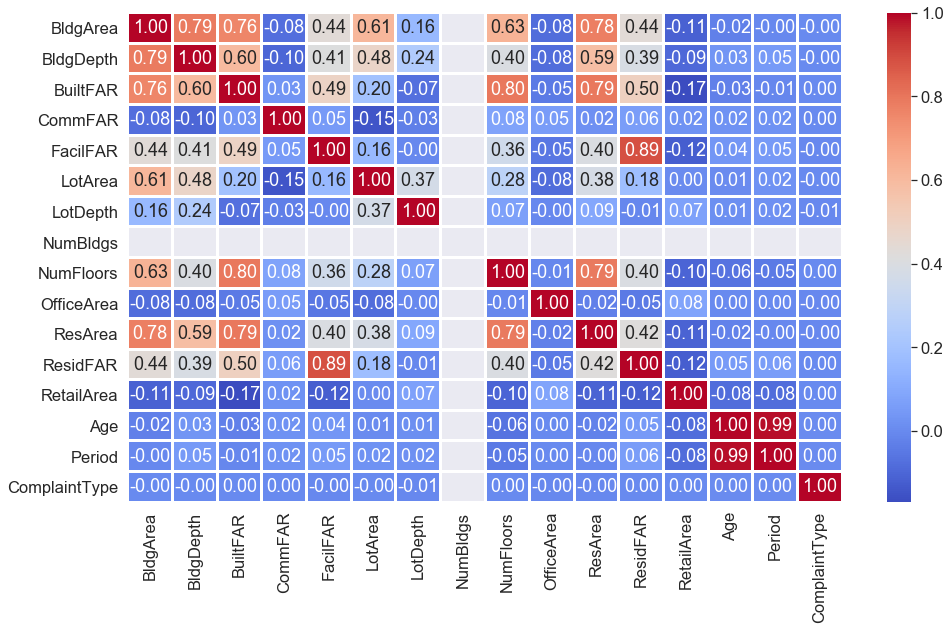

In [43]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

### Data Preprocessing

### Treat Duplicate Values

In [44]:
df.duplicated(keep='first').sum()

14968

In [45]:
df[df.duplicated(keep=False)]

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
0,1268,35.0,0.35,2.0,2.0,3650,95.00,1,1.67,2628,1268,0.90,2458,50,70,0
2,1910,30.0,0.65,2.0,1.0,2917,58.33,1,2.00,2628,1910,0.60,2458,-6,14,0
4,924,30.0,0.51,2.0,2.0,1800,100.00,1,2.00,2628,924,0.90,2458,75,95,0
10,1600,40.0,0.64,2.0,2.0,2500,100.00,1,2.00,2628,1600,0.90,2458,75,95,0
12,1782,33.0,0.62,2.0,2.0,2884,109.50,1,3.00,2628,1782,0.90,2458,45,65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89840,1050,34.0,0.42,2.0,1.0,2500,100.00,1,2.00,2628,1050,0.60,2458,80,100,1
89842,3132,55.0,1.65,2.0,2.0,1898,94.90,1,2.00,2628,2088,1.10,2458,90,110,1
89845,1998,37.0,1.11,2.0,1.0,1800,100.00,1,3.00,2628,1998,0.60,2458,40,60,1
89849,2340,46.0,0.90,2.0,4.8,2500,100.00,1,2.00,2628,2000,3.44,2458,65,85,1


In [46]:
df.drop_duplicates(keep='first',ignore_index=True, inplace=True)

In [47]:
df

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
0,1268,35.0,0.35,2.0,2.0,3650,95.00,1,1.67,2628,1268,0.90,2458,50,70,0
1,7839,45.0,3.08,2.0,3.0,4275,45.00,1,5.00,2628,6018,3.00,2458,83,103,0
2,1910,30.0,0.65,2.0,1.0,2917,58.33,1,2.00,2628,1910,0.60,2458,-6,14,0
3,1968,40.0,0.39,2.0,1.0,5000,100.00,1,2.50,2628,1968,0.60,2458,75,95,1
4,924,30.0,0.51,2.0,2.0,1800,100.00,1,2.00,2628,924,0.90,2458,75,95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74881,7839,83.0,1.99,1.0,2.4,10400,124.68,1,3.00,2628,2000,1.25,2458,-13,7,1
74882,2340,46.0,0.90,2.0,2.0,5140,106.80,1,2.00,2628,2000,0.90,2458,65,85,1
74883,3432,52.0,1.51,2.0,2.0,2266,103.00,1,3.00,2628,3432,1.10,2458,35,55,1
74884,2320,58.0,0.93,2.0,2.0,2500,100.00,1,2.00,2628,2320,0.90,2458,80,100,1


### HEAT/HOT WATER = 0; OTHERS = 1

### Train Test Split

In [48]:
X = df.iloc[:,0:15]
y = df.iloc[:,15]

### Treat Imbalance Data

In [49]:
y.value_counts()

1    37551
0    37335
Name: ComplaintType, dtype: int64

In [50]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [51]:
new_X, new_y = ros.fit_resample(X, y)

In [52]:
new_y.value_counts()

1    37551
0    37551
Name: ComplaintType, dtype: int64

In [53]:
new_X

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period
0,1268,35.00,0.35,2.0,2.0,3650,95.00,1,1.67,2628,1268,0.90,2458,50,70
1,7839,45.00,3.08,2.0,3.0,4275,45.00,1,5.00,2628,6018,3.00,2458,83,103
2,1910,30.00,0.65,2.0,1.0,2917,58.33,1,2.00,2628,1910,0.60,2458,-6,14
3,1968,40.00,0.39,2.0,1.0,5000,100.00,1,2.50,2628,1968,0.60,2458,75,95
4,924,30.00,0.51,2.0,2.0,1800,100.00,1,2.00,2628,924,0.90,2458,75,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75097,3300,55.00,1.74,2.0,4.8,1900,95.00,1,3.00,2628,3300,3.44,2458,95,115
75098,2580,50.00,1.03,2.0,2.0,2500,100.00,1,2.50,2628,2040,0.90,2458,50,70
75099,2664,39.75,1.14,2.0,2.0,2334,100.00,1,3.00,2628,2664,0.90,2458,1,21
75100,7839,102.00,3.08,2.0,6.5,10400,124.68,1,6.00,2628,6018,6.02,2458,73,93


In [54]:
new_X.values, new_y.values

(array([[ 1.268e+03,  3.500e+01,  3.500e-01, ...,  2.458e+03,  5.000e+01,
          7.000e+01],
        [ 7.839e+03,  4.500e+01,  3.080e+00, ...,  2.458e+03,  8.300e+01,
          1.030e+02],
        [ 1.910e+03,  3.000e+01,  6.500e-01, ...,  2.458e+03, -6.000e+00,
          1.400e+01],
        ...,
        [ 2.664e+03,  3.975e+01,  1.140e+00, ...,  2.458e+03,  1.000e+00,
          2.100e+01],
        [ 7.839e+03,  1.020e+02,  3.080e+00, ...,  2.458e+03,  7.300e+01,
          9.300e+01],
        [ 1.960e+03,  3.500e+01,  7.000e-01, ...,  2.458e+03,  3.600e+01,
          5.600e+01]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [55]:
X_train, X_test, y_train, y_test = train_test_split(new_X.values, new_y.values, test_size=0.2, random_state=0)

In [56]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60081, 15), (15021, 15), (60081,), (15021,))

### Feature Scaling

In [57]:
X_train

array([[2.120e+03, 5.300e+01, 8.500e-01, ..., 2.458e+03, 6.500e+01,
        1.000e+02],
       [5.310e+03, 1.060e+02, 9.900e-01, ..., 2.458e+03, 6.800e+01,
        8.800e+01],
       [3.340e+03, 5.200e+01, 1.520e+00, ..., 2.458e+03, 1.300e+01,
        3.300e+01],
       ...,
       [3.500e+03, 5.058e+01, 7.600e-01, ..., 2.458e+03, 1.500e+01,
        3.500e+01],
       [2.709e+03, 5.000e+01, 1.350e+00, ..., 2.458e+03, 1.010e+02,
        1.210e+02],
       [1.116e+03, 3.450e+01, 3.900e-01, ..., 2.458e+03, 7.000e+01,
        9.000e+01]])

In [58]:
scaler = StandardScaler()

In [59]:
X_train_scaled = scaler.fit_transform(X_train)

In [60]:
X_test_scaled = scaler.transform(X_test)

In [61]:
X_train_scaled

array([[-0.4886674 ,  0.09511982, -0.32433289, ...,  0.18139025,
         0.22932016,  0.74406443],
       [ 1.01756922,  2.64169132, -0.13819805, ...,  0.18139025,
         0.33338617,  0.32672869],
       [ 0.08738548,  0.04707131,  0.56645531, ...,  0.18139025,
        -1.57449066, -1.58606012],
       ...,
       [ 0.16293339, -0.02115759, -0.44399101, ...,  0.18139025,
        -1.50511332, -1.51650416],
       [-0.21055663, -0.04902573,  0.34043442, ...,  0.18139025,
         1.47811226,  1.47440198],
       [-0.96273058, -0.79377777, -0.93591883, ...,  0.18139025,
         0.40276351,  0.39628465]])

In [62]:
X_test_scaled

array([[-0.806913  , -0.33731684, -0.57694447, ...,  0.18139025,
        -0.11756654, -0.12538503],
       [ 0.24414741,  0.23926538,  0.28725304, ...,  0.18139025,
         0.92309355,  0.91795432],
       [-0.80974605, -1.73072389, -0.72319328, ...,  0.18139025,
         0.92309355,  0.91795432],
       ...,
       [ 0.621887  ,  0.33536242, -0.96250952, ...,  0.18139025,
        -1.67855666, -1.69039405],
       [-0.09676257, -0.04902573,  0.93872501, ...,  0.18139025,
        -0.81133993, -0.8209446 ],
       [ 0.21581694,  0.23926538,  0.44679719, ...,  0.18139025,
         0.57620686,  0.57017454]])

In [63]:
y_train

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [64]:
y_test

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

### Model Training

### Using XGBoost (Scikit-Learn)

In [65]:
xgbmodel = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.16999999999999998, 
              max_delta_step=0, max_depth=9, min_child_weight=2, missing=None,
              n_estimators=700, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.5, verbosity=1)

In [66]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.499967
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.509354
[2]	validation_0-error:0.509886
[3]	validation_0-error:0.508954
[4]	validation_0-error:0.511084
[5]	validation_0-error:0.510419
[6]	validation_0-error:0.510618
[7]	validation_0-error:0.513348
[8]	validation_0-error:0.512349
[9]	validation_0-error:0.513281
[10]	validation_0-error:0.511883
Stopping. Best iteration:
[0]	validation_0-error:0.499967



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.16999999999999998, max_delta_step=0, max_depth=9,
              min_child_weight=2, missing=None, n_estimators=700, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [67]:
y_pred = xgbmodel.predict(X_test_scaled)

In [68]:
y_pred

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

### Model Evaluation

In [69]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[1798, 5725],
       [1785, 5713]], dtype=int64)

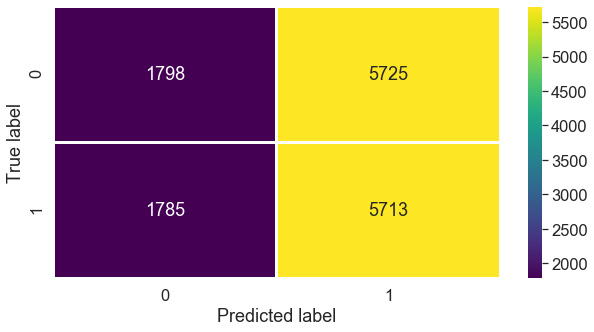

In [70]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [71]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.24      0.32      7523
           1       0.50      0.76      0.60      7498

    accuracy                           0.50     15021
   macro avg       0.50      0.50      0.46     15021
weighted avg       0.50      0.50      0.46     15021



### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [72]:
X.columns

Index(['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'Age', 'Period'],
      dtype='object')

In [73]:
xgbmodel.get_booster().feature_names = ['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea','ResidFAR', 'RetailArea', 'Age', 'Period']

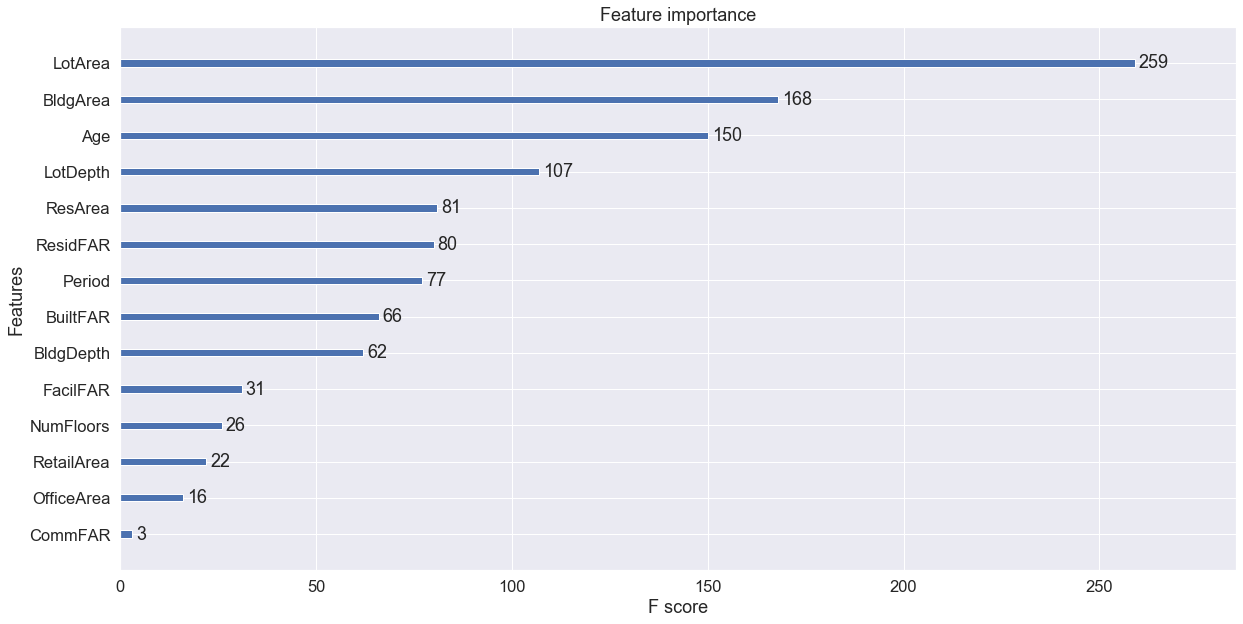

In [74]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

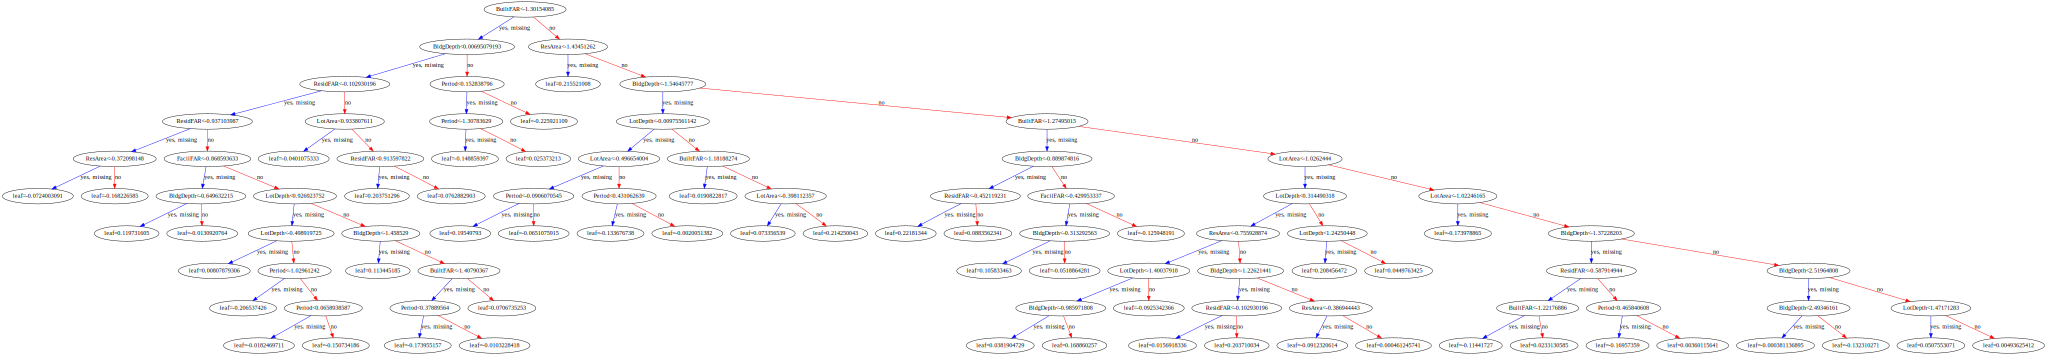

In [76]:
xgb.to_graphviz(xgbmodel,num_trees=10)

### Cross-Validation

In [ ]:
#cv = cross_val_score(xgbmodel,X_train_scaled,y_train,cv=5,verbose=1,scoring='accuracy')

In [ ]:
#cv.mean()

### Model Tuning

### Using RandomSearchCV

In [3]:
df = pd.read_csv("bronxbinarytrain.csv", nrows=2000)

In [4]:
df.duplicated(keep='first').sum()

25

In [5]:
df[df.duplicated(keep=False)]

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
10,1600,40.00,0.64,2.0,2.0,2500,100.00,1,2.0,2628,1600,0.90,2458,75,95,0
27,3000,60.00,1.50,2.0,4.8,2000,100.00,1,3.0,2628,3000,3.44,2458,7,27,0
42,1840,40.00,0.80,2.0,2.0,2300,100.00,1,2.0,2628,1840,0.90,2458,40,60,0
64,2280,38.00,1.14,2.0,4.8,2000,100.00,1,3.0,2628,2280,2.43,2458,0,20,0
70,1728,36.00,0.69,2.0,2.0,2492,100.00,1,2.0,2628,1152,0.90,2458,35,55,0
75,1266,31.67,0.63,2.0,4.8,2000,100.00,1,2.0,2628,1266,3.44,2458,8,28,0
86,1728,36.00,0.69,2.0,2.0,2492,100.00,1,2.0,2628,1152,0.90,2458,35,55,0
216,1266,31.67,0.63,2.0,4.8,2000,100.00,1,2.0,2628,1266,3.44,2458,8,28,0
317,2340,46.00,0.90,0.5,1.0,10400,124.68,1,2.0,2628,2000,0.60,2458,65,85,1
413,2340,46.00,0.90,0.5,1.0,10400,124.68,1,2.0,2628,2000,0.60,2458,65,85,1


In [6]:
df.drop_duplicates(keep='first',ignore_index=True, inplace=True)

In [7]:
df

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
0,1268,35.0,0.35,2.0,2.0,3650,95.00,1,1.67,2628,1268,0.90,2458,50,70,0
1,7839,45.0,3.08,2.0,3.0,4275,45.00,1,5.00,2628,6018,3.00,2458,83,103,0
2,1910,30.0,0.65,2.0,1.0,2917,58.33,1,2.00,2628,1910,0.60,2458,-6,14,0
3,1968,40.0,0.39,2.0,1.0,5000,100.00,1,2.50,2628,1968,0.60,2458,75,95,1
4,924,30.0,0.51,2.0,2.0,1800,100.00,1,2.00,2628,924,0.90,2458,75,95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,3090,53.0,1.86,2.0,3.0,1658,100.00,1,2.00,2628,2060,3.00,2458,80,100,1
1971,1444,25.0,0.62,2.0,6.0,2347,94.00,1,2.00,2628,1444,6.00,2458,80,100,1
1972,1540,44.0,0.68,2.0,2.0,2250,90.00,1,1.00,2628,880,0.90,2458,40,60,1
1973,1995,35.0,0.87,2.0,1.0,2300,100.00,1,2.00,2628,1330,0.60,2458,50,70,1


### HEAT/HOT WATER = 0; OTHERS = 1

### Train Test Split

In [8]:
X = df.iloc[:,0:15]
y = df.iloc[:,15]

In [9]:
y.value_counts()

1    1404
0     571
Name: ComplaintType, dtype: int64

In [10]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [11]:
new_X, new_y = ros.fit_resample(X, y)

In [12]:
new_y.value_counts()

1    1404
0    1404
Name: ComplaintType, dtype: int64

In [13]:
new_X

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period
0,1268,35.0,0.35,2.0,2.0,3650,95.00,1,1.67,2628,1268,0.90,2458,50,70
1,7839,45.0,3.08,2.0,3.0,4275,45.00,1,5.00,2628,6018,3.00,2458,83,103
2,1910,30.0,0.65,2.0,1.0,2917,58.33,1,2.00,2628,1910,0.60,2458,-6,14
3,1968,40.0,0.39,2.0,1.0,5000,100.00,1,2.50,2628,1968,0.60,2458,75,95
4,924,30.0,0.51,2.0,2.0,1800,100.00,1,2.00,2628,924,0.90,2458,75,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2803,2138,55.0,1.07,2.0,4.8,2000,100.00,1,2.00,2628,2138,2.43,2458,90,110
2804,7839,112.0,3.08,2.0,4.0,10400,124.68,1,5.00,2628,6018,4.00,2458,77,97
2805,2501,40.0,1.00,2.0,2.0,2500,100.00,1,1.00,2628,2000,1.25,2458,101,121
2806,2400,38.0,1.18,2.0,4.8,2033,100.00,1,3.00,2628,2400,3.44,2458,5,25


In [14]:
new_X.values, new_y.values

(array([[ 1.268e+03,  3.500e+01,  3.500e-01, ...,  2.458e+03,  5.000e+01,
          7.000e+01],
        [ 7.839e+03,  4.500e+01,  3.080e+00, ...,  2.458e+03,  8.300e+01,
          1.030e+02],
        [ 1.910e+03,  3.000e+01,  6.500e-01, ...,  2.458e+03, -6.000e+00,
          1.400e+01],
        ...,
        [ 2.501e+03,  4.000e+01,  1.000e+00, ...,  2.458e+03,  1.010e+02,
          1.210e+02],
        [ 2.400e+03,  3.800e+01,  1.180e+00, ...,  2.458e+03,  5.000e+00,
          2.500e+01],
        [ 7.839e+03,  9.450e+01,  3.080e+00, ...,  2.458e+03,  6.100e+01,
          8.100e+01]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(new_X.values, new_y.values, test_size=0.2, random_state=0)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2246, 15), (562, 15), (2246,), (562,))

In [17]:
X_train

array([[ 3.051e+03,  4.000e+01,  1.220e+00, ...,  2.458e+03, -5.000e+00,
         1.500e+01],
       [ 3.750e+03,  7.500e+01,  1.580e+00, ...,  2.458e+03,  6.900e+01,
         8.900e+01],
       [ 1.431e+03,  2.833e+01,  4.500e-01, ...,  2.458e+03,  5.500e+01,
         7.500e+01],
       ...,
       [ 2.500e+03,  5.000e+01,  8.600e-01, ...,  2.458e+03,  4.000e+01,
         6.000e+01],
       [ 3.144e+03,  5.200e+01,  6.300e-01, ...,  2.458e+03,  7.500e+01,
         9.500e+01],
       [ 2.044e+03,  3.533e+01,  6.800e-01, ...,  2.458e+03, -8.000e+00,
         1.200e+01]])

In [18]:
scaler = StandardScaler()

In [19]:
X_train_scaled = scaler.fit_transform(X_train)

In [20]:
X_test_scaled = scaler.transform(X_test)

In [21]:
X_train_scaled

array([[-0.02806873, -0.54591141,  0.14043083, ...,  0.18644718,
        -2.04121846, -2.04501457],
       [ 0.31540738,  1.19261771,  0.63469258, ...,  0.18644718,
         0.44997848,  0.44640631],
       [-0.82410777, -1.12558669, -0.91674014, ...,  0.18644718,
        -0.02132905, -0.02494359],
       ...,
       [-0.29882028, -0.04918881, -0.35383092, ...,  0.18644718,
        -0.5263014 , -0.52996133],
       [ 0.01762981,  0.05015571, -0.66960926, ...,  0.18644718,
         0.65196742,  0.6484134 ],
       [-0.52289053, -0.77788087, -0.6009618 , ...,  0.18644718,
        -2.14221293, -2.14601812]])

In [22]:
X_test_scaled

array([[ 2.3246689 , -0.14853333, -1.13641203, ...,  0.18644718,
        -0.02132905,  0.44640631],
       [-0.8589959 , -0.75701852, -0.84809267, ...,  0.18644718,
        -1.40158681, -1.40532542],
       [-0.67816728, -0.74460046, -0.5872323 , ...,  0.18644718,
        -0.69462552, -0.69830058],
       ...,
       [-0.94351363, -0.74460046, -0.46366687, ...,  0.18644718,
         0.11333024,  0.10972781],
       [-0.96120339, -0.9432895 , -0.64215028, ...,  0.18644718,
        -1.56991093, -1.57366467],
       [-0.59856338, -0.74460046, -0.49112585, ...,  0.18644718,
         0.82029154,  0.81675265]])

In [23]:
y_train

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [24]:
y_test

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,

In [25]:
model = XGBClassifier(random_state=0, n_estimators=300, objective='binary:logistic')

In [26]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [27]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='accuracy')

In [28]:
randm.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=300,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                

In [29]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning rate=0.16999999999999998, learning_rate=0.1,
              max_delta_step=0, max_depth=9, min_child_weight=2, missing=None,
              n_estimators=700, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.5, verbosity=1)

In [30]:
randm.best_score_

0.7346478594407324

In [31]:
randm.best_params_

{'subsample': 0.5,
 'n_estimators': 700,
 'min_child_weight': 2,
 'max_depth': 9,
 'learning rate': 0.16999999999999998,
 'gamma': 0,
 'colsample_bytree': 0.6}

{'subsample': 0.5,
 'n_estimators': 700,
 'min_child_weight': 2,
 'max_depth': 9,
 'learning rate': 0.16999999999999998,
 'gamma': 0,
 'colsample_bytree': 0.6}

### Save the Model

In [77]:
filename = 'modelbinarybronx.sav'
dump(xgbmodel,open(filename,'wb'))